### Imports

In [1]:
%pylab inline
from os.path import abspath, join
from nipype.interfaces.fsl.model import Level1Design, FEATModel, FILMGLS
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node
import pandas as pd
from glob import glob

Populating the interactive namespace from numpy and matplotlib


### Experiment Variables

In [2]:
experiment_dir = abspath('.')
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-s358']

# list of task identifiers
task_list = ['stroop']

# TR of functional images
TR = .68


###  Specify Contrasts

In [3]:
# Condition names
condition_names = ['response']

# Contrasts
cont01 = ['motor','T', condition_names, [1]]

contrast_list = [cont01]

# Set up Nodes

### Specify GLM Model for Motor Contrast

In [32]:
def subjectinfo(subject_id, task, inspect_inputs=False):
    
    from glob import glob
    import numpy as np
    import pandas as pd
    from os.path import join
    from nipype.interfaces.base import Bunch
    
    base_dir = '/home/jovyan/work/output'
    
    # strip "sub" from beginning of subject_id if provided
    subject_id = subject_id.replace('sub-','')
    
    ## Get the Events File
    
    # Read the TSV file and convert to pandas dataframe
    event_file = glob(join(base_dir,
                           'Data',
                           'sub-%s' % subject_id,
                           '*', 'func',
                           '*%s*events.tsv' % task))[0]
    events_df = pd.read_csv(event_file,sep = '\t')
    # set duration and add response column
    events_df.loc[:,'duration'] = .1
    events_df.loc[:,'trial_type'] = 'response'
    ## Get the Confounds File (output of fmriprep)
    
    # Read the TSV file and convert to pandas dataframe
    confounds_file = glob(join(base_dir,
                               'Data',
                               'sub-%s' % subject_id,
                               '*', 'func',
                               '*%s*confounds.tsv' % task))[0]
    confounds_df = pd.read_csv(confounds_file, sep = '\t', na_values=['n/a']).fillna(0)
    # select relevant regressors
    regressor_names = ['FramewiseDisplacement', 
                       'aCompCor0',
                       'aCompCor1',
                       'aCompCor2',
                       'aCompCor3',
                       'aCompCor4',
                       'aCompCor5']
    # convert selected regressors in dataframe to list of lists
    regressors = confounds_df.loc[:,regressor_names].values.T.tolist()
    
    
    
    subjectinfo = Bunch(conditions=['response'],
                        onsets=[events_df.onset.tolist()],
                         durations=[events_df.duration.tolist()],
                         amplitudes=None,
                         tmod=None,
                         pmod=None,
                         regressor_names=regressor_names,
                         regressors=regressors)
    if inspect_inputs==True:
        return events_df, confounds_df
    else:
        return subjectinfo  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id', 'task'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

View one events file used in subject info

In [33]:
events_df,confounds_df = subjectinfo('s358','stroop',True)
events_df.head()

,onset,duration,response_time,block_duration,correct,experiment_exp_id,stim_color,stim_word,timing_post_trial,trial_num,worker_id,trial_type
0,3.510,0.1,0.807,2272.0,1.0,stroop,blue,red,0.0,0.0,s358,response
1,5.785,0.1,0.458,2000.0,1.0,stroop,blue,red,0.0,1.0,s358,response
2,7.786,0.1,0.412,2000.0,1.0,stroop,blue,blue,0.0,2.0,s358,response
3,9.788,0.1,0.499,2000.0,1.0,stroop,green,green,0.0,3.0,s358,response
4,11.791,0.1,0.508,2000.0,1.0,stroop,blue,green,0.0,4.0,s358,response


View bunch

In [34]:
bunch = subjectinfo('s358','stroop')
print('Bunch Keys: ')
[i[0] for i in bunch.items()]

Bunch Keys: 


['amplitudes',
 'pmod',
 'durations',
 'regressor_names',
 'tmod',
 'regressors',
 'conditions',
 'onsets']

### Specify Input and Output Stream

In [35]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'task',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': join('Data', '{subject_id}','*','func',
                         '*{task}*preproc.nii.gz')}
selectfiles = Node(SelectFiles(templates,
                               base_directory = experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory = experiment_dir,
                         container=output_dir),
                name="datasink")

"""
# Use the following DataSink output substitutions
substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions
"""

"\n# Use the following DataSink output substitutions\nsubstitutions = [('_subject_id_', '')]\nsubjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))\n               for f in fwhm\n               for sub in subject_list]\nsubstitutions.extend(subjFolders)\ndatasink.inputs.substitutions = substitutions\n"

### Model Specification

In [36]:
# SpecifyModel - Generates FSL-specific Model
modelspec = Node(SpecifyModel(input_units='secs',
                              time_repetition=TR,
                              high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an FSL design matrix
level1design = Node(Level1Design(bases={'dgamma':{'derivs': True}},
                                 interscan_interval=TR,
                                 model_serial_correlations=True,
                                 contrasts=contrast_list),
                    name="level1design")

# FEATmodel
level1model = Node(FEATModel(), name="FEATModel")

# FILMGLs
filmgls = Node(FILMGLS(autocorr_noestimate = True), name="FILMGLS")

# Run as separate nodes

In [61]:
getsubjectinfo.inputs.subject_id = 'sub-s358'
getsubjectinfo.inputs.task = 'stroop'
subject_info = getsubjectinfo.run().outputs.subject_info

selectfiles.inputs.subject_id = 'sub-s358'
selectfiles.inputs.task = 'stroop'
selectfiles_out = selectfiles.run()

modelspec.inputs.subject_info = subject_info
modelspec.inputs.functional_runs = selectfiles_out.outputs.func
modelspec_out = modelspec.run()

level1design.inputs.session_info = modelspec_out.outputs.session_info
level1design_out = level1design.run()
level1design_out.outputs

level1model.inputs.fsf_file = level1design_out.outputs.fsf_files
level1model.inputs.ev_files = level1design_out.outputs.ev_files
out=level1model.run()

"""
filmgls.inputs.in_file = selectfiles_out.outputs.func
filmgls.inputs.design_file = out.outputs.design_file
filmgls.inputs.tcon_file = out.outputs.con_file
filmgls.inputs.fcon_file = out.outputs.fcon_file
fil_out = filmgls.run()
"""

170512-02:01:26,333 workflow INFO:
	 Executing node getsubjectinfo in dir: /tmp/tmp9JQ2q1/l1analysis/getsubjectinfo
170512-02:01:26,516 workflow INFO:
	 Executing node selectfiles in dir: /tmp/tmpneuANK/l1analysis/selectfiles
170512-02:01:26,539 workflow INFO:
	 Executing node modelspec in dir: /tmp/tmp3EnYZk/l1analysis/modelspec
170512-02:01:27,156 workflow INFO:
	 Executing node level1design in dir: /tmp/tmpXC8BLG/l1analysis/level1design
170512-02:01:27,618 workflow INFO:
	 Executing node FEATModel in dir: /tmp/tmpaa7j3e/l1analysis/FEATModel
170512-02:01:27,638 workflow INFO:
	 Running: feat_model run0 
170512-02:01:27,702 interface INFO:
	 stderr 2017-05-12T02:01:27.702157:feat_model: /opt/mcr/v91/bin/glnxa64/libtiff.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libgd.so.3)
170512-02:01:28,204 interface INFO:
	 stderr 2017-05-12T02:01:28.204597:/usr/share/fsl/5.0/bin/wpng: /opt/mcr/v91/bin/glnxa64/libtiff.so.5: no version information available (requir

'\nfilmgls.inputs.in_file = selectfiles_out.outputs.func\nfilmgls.inputs.design_file = out.outputs.design_file\nfilmgls.inputs.tcon_file = out.outputs.con_file\nfilmgls.inputs.fcon_file = out.outputs.fcon_file\nfil_out = filmgls.run()\n'

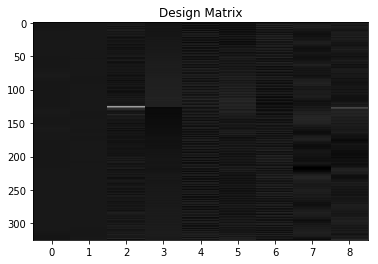

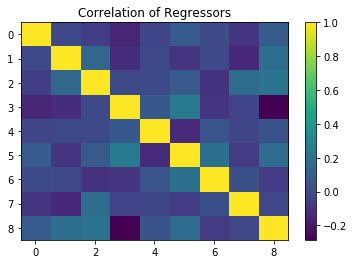

In [13]:
desmtx=numpy.loadtxt(out.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')
plt.title('Design Matrix')
plt.show()
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Correlation of Regressors')

In [ ]:
import nilearn.plotting
import nilearn.image
t_map = fil_out.outputs.zstats
nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

# Workflow

In [56]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('task', 'task')]),
                    (infosource, getsubjectinfo, [('subject_id','subject_id'),
                                                 ('task', 'task')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1model, [('ev_files', 'ev_files'),
                                                 ('fsf_files','fsf_file')]),
                    (selectfiles, filmgls, [('func', 'in_file')]),
                    (level1model, filmgls, [('design_file', 'design_file'),
                                            ('con_file', 'tcon_file'),
                                            ('fcon_file', 'fcon_file')])
                    ])

### Visualize Workflow

170512-01:57:52,18 workflow INFO:
	 Converting dotfile: /home/jovyan/work/output/workingdir/l1analysis/graph.dot to png format


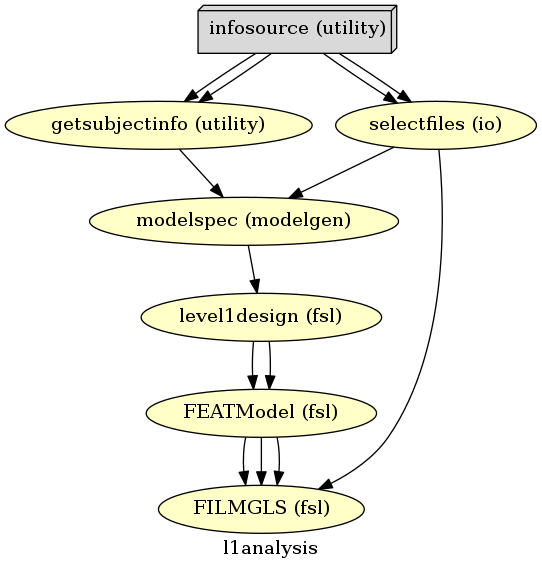

In [57]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=join(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

### Run the Workflow


In [60]:
l1analysis.run()

170512-01:58:25,781 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
170512-01:58:25,841 workflow INFO:
	 Running serially.
170512-01:58:25,842 workflow INFO:
	 Executing node selectfiles.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/selectfiles
170512-01:58:25,865 workflow INFO:
	 Executing node getsubjectinfo.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/getsubjectinfo
170512-01:58:26,26 workflow INFO:
	 Executing node modelspec.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/modelspec
170512-01:58:26,558 workflow INFO:
	 Executing node level1design.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/level1design
170512-01:58:26,957 workflow INFO:
	 Executing node FEATModel.a0 in dir: /home/jovyan/work/output/workingdir/l1analysis/_subject_id_sub-s358_task_stroop/FEATModel
170512-01:

RuntimeError: Workflow did not execute cleanly. Check log for details

### Visualize Design Matrix

In [ ]:
!tree datasink/1stLevel/_subject*


In [ ]:
desmtx=numpy.loadtxt(out.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')
plt.title('Design Matrix')
plt.show()
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()
plt.title('Correlation of Regressors')

### Visualize Results

In [ ]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds102/sub-01/anat/sub-01_T1w.nii.gz'
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm4/spmT_0001.nii', title='average - fwhm=4',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
plot_stat_map(
    '/output/datasink/1stLevel/sub-01_fwhm8/spmT_0001.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=3, display_mode='z', cut_coords=(-30, -15, 0, 15, 30), dim=-1)